# Flight Delay Analysis - Feature Engineering

## Phase 3: Creating Features for Model Training

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

# Import feature engineering functions
from src.data.feature_engineering import (
    create_basic_features,
    encode_categorical_features,
    select_features_for_modeling,
    feature_engineering_pipeline
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Imports complete")

✓ Imports complete


---
## Part 1: Load Cleaned Data
---

In [2]:
# Load the cleaned dataset from preprocessing
input_path = '../data/processed/flight_delays_cleaned.csv'
df_clean = pd.read_csv(input_path)

print(f"Cleaned data shape: {df_clean.shape}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 60)
print("CLEANED DATA OVERVIEW")
print("=" * 60)
print(f"\nColumns ({len(df_clean.columns)}):")
for i, col in enumerate(df_clean.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\nSample data:")
df_clean.head()

Cleaned data shape: (1527160, 17)
Memory usage: 750.04 MB

CLEANED DATA OVERVIEW

Columns (17):
   1. Carrier Code
   2. Date (MM/DD/YYYY)
   3. Flight Number
   4. Tail Number
   5. Origin Airport
   6. Scheduled Arrival Time
   7. Actual Arrival Time
   8. Scheduled Elapsed Time (Minutes)
   9. Actual Elapsed Time (Minutes)
  10. Arrival Delay (Minutes)
  11. Wheels-on Time
  12. Taxi-In time (Minutes)
  13. Delay Carrier (Minutes)
  14. Delay Weather (Minutes)
  15. Delay National Aviation System (Minutes)
  16. Delay Security (Minutes)
  17. Delay Late Aircraft Arrival (Minutes)

Sample data:


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,9E,2019-01-01,3280,N8688C,GNV,07:23,07:22,83,81,-1,07:14,8,0,0,0,0,0
1,9E,2019-01-01,3283,N8886A,TLH,16:39,16:25,72,64,-14,16:18,7,0,0,0,0,0
2,9E,2019-01-01,3286,N915XJ,JAN,18:23,18:32,85,99,9,18:18,14,0,0,0,0,0
3,9E,2019-01-01,3289,N311PQ,BMI,17:07,17:00,112,110,-7,16:55,5,0,0,0,0,0
4,9E,2019-01-01,3290,N931XJ,CAK,08:09,07:37,129,100,-32,07:31,6,0,0,0,0,0


In [3]:
# Check data quality
print("\n" + "=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)

print(f"\nTotal rows: {len(df_clean):,}")
print(f"Missing values: {df_clean.isna().sum().sum()}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")

print(f"\nTarget variable (Arrival Delay) statistics:")
print(df_clean['Arrival Delay (Minutes)'].describe())


DATA QUALITY CHECK

Total rows: 1,527,160
Missing values: 0
Duplicate rows: 0

Target variable (Arrival Delay) statistics:
count    1.527160e+06
mean     3.105137e+00
std      5.249457e+01
min     -8.600000e+01
25%     -1.600000e+01
50%     -8.000000e+00
75%      3.000000e+00
max      1.694000e+03
Name: Arrival Delay (Minutes), dtype: float64


---
## Part 2: Feature Engineering Pipeline
---

### 2.1 Run Feature Engineering Pipeline

In [4]:
# Run the complete feature engineering pipeline
output_path = '../data/processed/flight_delays_engineered.csv'

df_engineered, feature_cols, label_encoders = feature_engineering_pipeline(
    input_path=input_path,
    output_path=output_path
)

print("\n✓ Feature engineering pipeline complete!")


FEATURE ENGINEERING PIPELINE (SIMPLIFIED)

Loading data from: ../data/processed/flight_delays_cleaned.csv
✓ Loaded 1,527,160 rows, 17 columns

CREATING BASIC FEATURES
✓ Created IsWeekend
✓ Created Is_Holiday_Period
✓ Created Season
✓ Created Is_Delayed

Feature summary:
  - IsWeekend: 409,624 (26.82%)
  - Is_Holiday_Period: 172,663 (11.31%)
  - Season: {'Spring': 424732, 'Summer': 407486, 'Winter': 362732, 'Fall': 332210}
  - Is_Delayed: 232,861 (15.25%)

ENCODING CATEGORICAL FEATURES

One-hot encoding Carrier Code...
✓ Created 11 carrier dummy variables

Label encoding Origin Airport...
✓ Encoded 173 unique airports

Label encoding Season...
✓ Encoded Season: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}

✓ Encoding complete. Total columns: 36

SELECTING FEATURES FOR MODELING

✓ Total features: 22

Features for modeling:
   1. Scheduled Elapsed Time (Minutes)
   2. Delay Carrier (Minutes)
   3. Delay Weather (Minutes)
   4. Delay National 

### 2.2 Inspect Engineered Features

In [5]:
# Inspect new features
print("\n" + "=" * 60)
print("NEW FEATURES CREATED")
print("=" * 60)

# Show new feature columns
new_features = [col for col in df_engineered.columns if col not in df_clean.columns]
print(f"\nNew features ({len(new_features)}):")
for i, col in enumerate(new_features, 1):
    print(f"  {i:2}. {col}")

print(f"\nSample of engineered data:")
display(df_engineered[['Date (MM/DD/YYYY)', 'IsWeekend', 'Is_Holiday_Period', 
                        'Season', 'Season_Encoded', 'Is_Delayed']].sample(10))


NEW FEATURES CREATED

New features (20):
   1. Month
   2. Day
   3. DayOfWeek
   4. IsWeekend
   5. Is_Holiday_Period
   6. Season
   7. Is_Delayed
   8. Carrier_9E
   9. Carrier_AA
  10. Carrier_AS
  11. Carrier_DL
  12. Carrier_EV
  13. Carrier_MQ
  14. Carrier_NK
  15. Carrier_OO
  16. Carrier_UA
  17. Carrier_WN
  18. Carrier_YX
  19. Origin_Airport_Encoded
  20. Season_Encoded

Sample of engineered data:


,Date (MM/DD/YYYY),IsWeekend,Is_Holiday_Period,Season,Season_Encoded,Is_Delayed
1172307,2019-12-12,0,0,Winter,3,0
999650,2023-10-03,0,0,Fall,0,0
369498,2024-03-08,0,0,Spring,1,0
1188325,2023-12-18,0,0,Winter,3,0
760656,2022-07-09,1,0,Summer,2,1
1176914,2024-12-13,0,0,Winter,3,0
702969,2022-06-21,0,0,Summer,2,0
1499406,2023-11-30,0,0,Fall,0,0
682080,2019-06-15,1,0,Summer,2,0
274250,2025-02-03,0,0,Winter,3,0


In [6]:
# Feature statistics
print("\n" + "=" * 60)
print("FEATURE STATISTICS")
print("=" * 60)

# IsWeekend
weekend_count = df_engineered['IsWeekend'].sum()
print(f"\nIsWeekend:")
print(f"  - Weekend flights: {weekend_count:,} ({weekend_count/len(df_engineered)*100:.2f}%)")
print(f"  - Weekday flights: {len(df_engineered)-weekend_count:,} ({(len(df_engineered)-weekend_count)/len(df_engineered)*100:.2f}%)")

# Is_Holiday_Period
holiday_count = df_engineered['Is_Holiday_Period'].sum()
print(f"\nIs_Holiday_Period:")
print(f"  - Holiday period flights: {holiday_count:,} ({holiday_count/len(df_engineered)*100:.2f}%)")
print(f"  - Regular flights: {len(df_engineered)-holiday_count:,} ({(len(df_engineered)-holiday_count)/len(df_engineered)*100:.2f}%)")

# Season
print(f"\nSeason distribution:")
season_dist = df_engineered['Season'].value_counts().sort_index()
for season, count in season_dist.items():
    print(f"  {season:8}: {count:,} ({count/len(df_engineered)*100:.2f}%)")

# Is_Delayed
delayed_count = df_engineered['Is_Delayed'].sum()
print(f"\nIs_Delayed:")
print(f"  - Delayed flights (>15 min): {delayed_count:,} ({delayed_count/len(df_engineered)*100:.2f}%)")
print(f"  - On-time flights (≤15 min): {len(df_engineered)-delayed_count:,} ({(len(df_engineered)-delayed_count)/len(df_engineered)*100:.2f}%)")


FEATURE STATISTICS

IsWeekend:
  - Weekend flights: 409,624 (26.82%)
  - Weekday flights: 1,117,536 (73.18%)

Is_Holiday_Period:
  - Holiday period flights: 172,663 (11.31%)
  - Regular flights: 1,354,497 (88.69%)

Season distribution:
  Fall    : 332,210 (21.75%)
  Spring  : 424,732 (27.81%)
  Summer  : 407,486 (26.68%)
  Winter  : 362,732 (23.75%)

Is_Delayed:
  - Delayed flights (>15 min): 232,861 (15.25%)
  - On-time flights (≤15 min): 1,294,299 (84.75%)


### 2.3 Encoded Features

In [7]:
# Check encoded features
print("\n" + "=" * 60)
print("ENCODED CATEGORICAL FEATURES")
print("=" * 60)

# Carrier Code (one-hot encoded)
carrier_cols = [col for col in df_engineered.columns if col.startswith('Carrier_')]
print(f"\nCarrier Code (one-hot encoded):")
print(f"  - Dummy columns: {len(carrier_cols)}")
for col in carrier_cols:
    count = df_engineered[col].sum()
    print(f"    {col}: {count:,} ({count/len(df_engineered)*100:.2f}%)")

# Origin Airport (label encoded)
print(f"\nOrigin Airport (label encoded):")
print(f"  - Unique airports: {df_engineered['Origin_Airport_Encoded'].nunique()}")
print(f"  - Encoding range: {df_engineered['Origin_Airport_Encoded'].min()} to {df_engineered['Origin_Airport_Encoded'].max()}")

# Show mapping (first 10)
print(f"\n  Sample encoding (Airport → Code):")
airport_mapping = pd.DataFrame({
    'Airport': df_engineered['Origin Airport'].head(10),
    'Encoded': df_engineered['Origin_Airport_Encoded'].head(10)
})
print(airport_mapping.to_string(index=False))

# Season (label encoded)
print(f"\nSeason (label encoded):")
season_mapping = df_engineered[['Season', 'Season_Encoded']].drop_duplicates().sort_values('Season_Encoded')
print(f"  Mapping:")
for _, row in season_mapping.iterrows():
    print(f"    {row['Season']:8} → {row['Season_Encoded']}")


ENCODED CATEGORICAL FEATURES

Carrier Code (one-hot encoded):
  - Dummy columns: 11
    Carrier_9E: 135,294 (8.86%)
    Carrier_AA: 39,905 (2.61%)
    Carrier_AS: 4,968 (0.33%)
    Carrier_DL: 1,038,169 (67.98%)
    Carrier_EV: 482 (0.03%)
    Carrier_MQ: 3,482 (0.23%)
    Carrier_NK: 48,865 (3.20%)
    Carrier_OO: 57,206 (3.75%)
    Carrier_UA: 27,981 (1.83%)
    Carrier_WN: 155,106 (10.16%)
    Carrier_YX: 15,702 (1.03%)

Origin Airport (label encoded):
  - Unique airports: 173
  - Encoding range: 0 to 172

  Sample encoding (Airport → Code):
Airport  Encoded
    GNV       67
    TLH      163
    JAN       86
    BMI       16
    CAK       28
    AGS        5
    LIT       94
    GNV       67
    EYW       56
    CAE       27

Season (label encoded):
  Mapping:
    Fall     → 0
    Spring   → 1
    Summer   → 2
    Winter   → 3


### 2.4 Features for Modeling

In [8]:
# Display modeling features
print("\n" + "=" * 60)
print("FEATURES FOR MODELING")
print("=" * 60)

print(f"\nTotal features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")

# Categorize features
delay_features = [col for col in feature_cols if 'Delay' in col]
carrier_features = [col for col in feature_cols if col.startswith('Carrier_')]
operational_features = [col for col in feature_cols if col in ['Scheduled Elapsed Time (Minutes)', 'IsWeekend', 'Is_Holiday_Period']]
encoded_features = [col for col in feature_cols if 'Encoded' in col]

print(f"\nFeature categories:")
print(f"  - Delay-related: {len(delay_features)}")
print(f"  - Carrier dummies: {len(carrier_features)}")
print(f"  - Operational: {len(operational_features)}")
print(f"  - Encoded categorical: {len(encoded_features)}")


FEATURES FOR MODELING

Total features: 22

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. Delay Carrier (Minutes)
   3. Delay Weather (Minutes)
   4. Delay National Aviation System (Minutes)
   5. Delay Security (Minutes)
   6. Delay Late Aircraft Arrival (Minutes)
   7. IsWeekend
   8. Is_Holiday_Period
   9. Is_Delayed
  10. Carrier_9E
  11. Carrier_AA
  12. Carrier_AS
  13. Carrier_DL
  14. Carrier_EV
  15. Carrier_MQ
  16. Carrier_NK
  17. Carrier_OO
  18. Carrier_UA
  19. Carrier_WN
  20. Carrier_YX
  21. Origin_Airport_Encoded
  22. Season_Encoded

Feature categories:
  - Delay-related: 6
  - Carrier dummies: 11
  - Operational: 3
  - Encoded categorical: 2


---
## Part 3: Feature Visualizations
---

✓ Saved visualization to: ../results/figures/feature_engineering_analysis.png


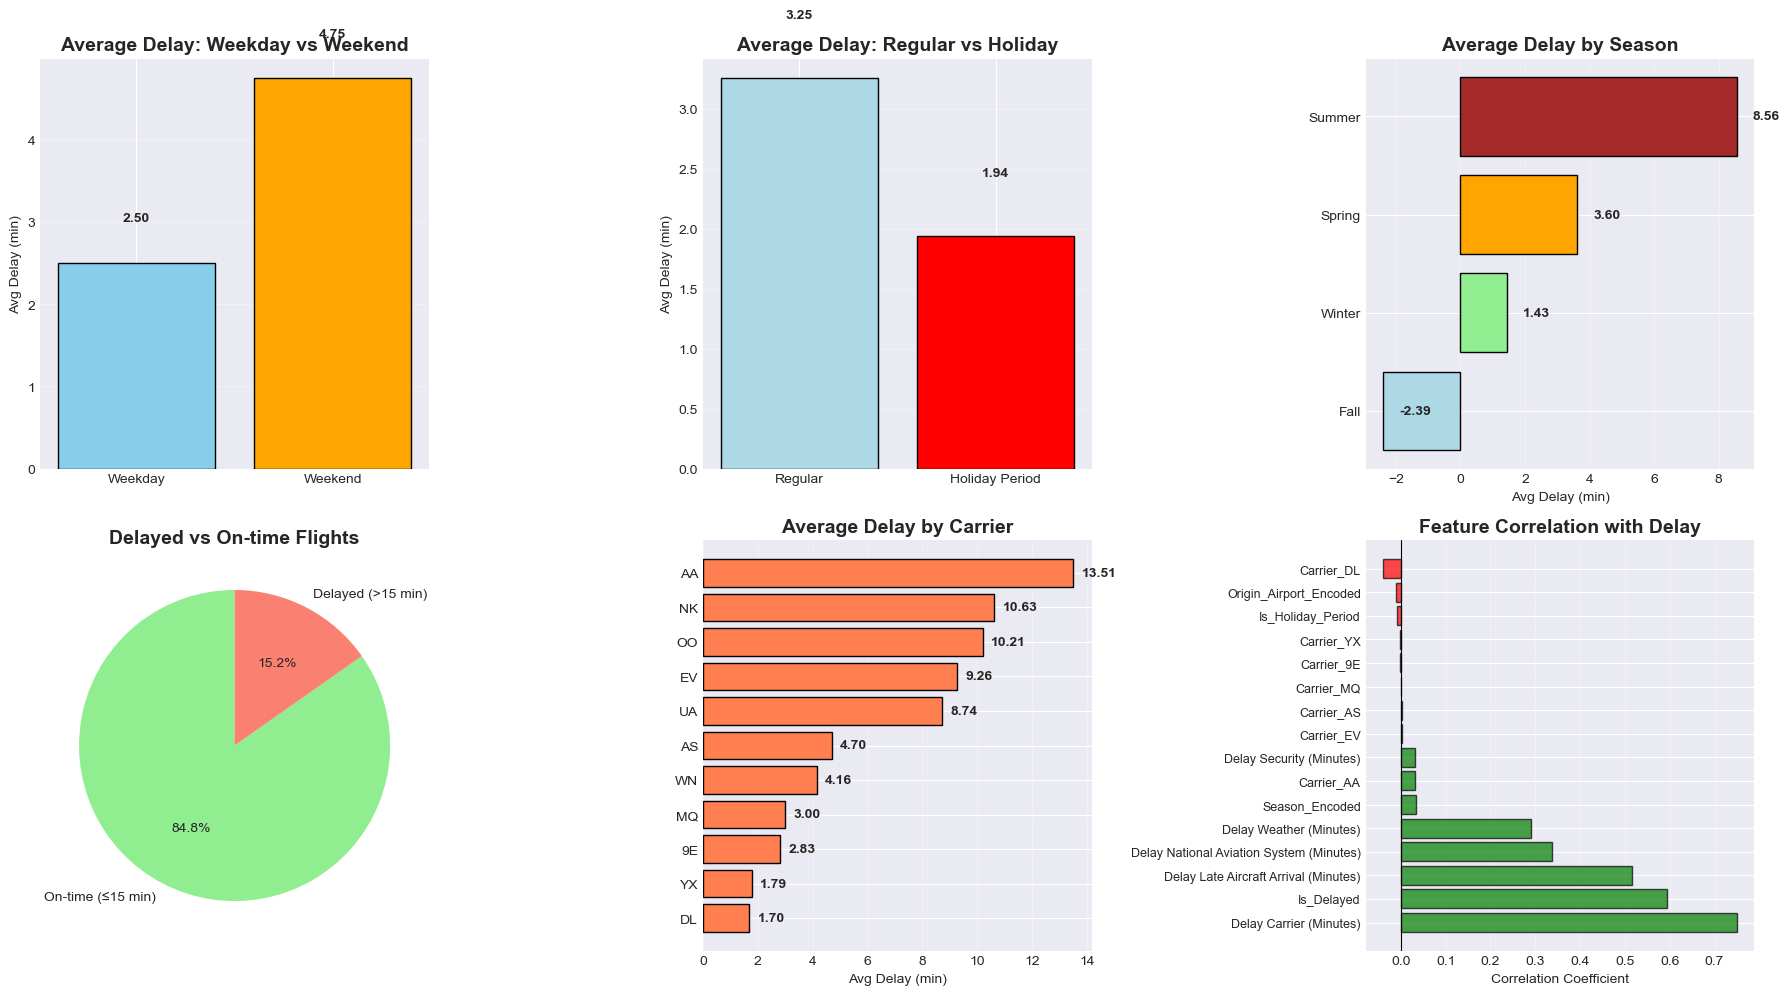

In [9]:
# Cell 17: Visualize new features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Weekend vs Weekday Delays
weekend_delay = df_engineered.groupby('IsWeekend')['Arrival Delay (Minutes)'].mean()
axes[0, 0].bar(['Weekday', 'Weekend'], weekend_delay.values, color=['skyblue', 'orange'], edgecolor='black')
axes[0, 0].set_title('Average Delay: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Avg Delay (min)')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(weekend_delay.values):
    axes[0, 0].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 2. Holiday vs Regular Delays
holiday_delay = df_engineered.groupby('Is_Holiday_Period')['Arrival Delay (Minutes)'].mean()
axes[0, 1].bar(['Regular', 'Holiday Period'], holiday_delay.values, color=['lightblue', 'red'], edgecolor='black')
axes[0, 1].set_title('Average Delay: Regular vs Holiday', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Avg Delay (min)')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(holiday_delay.values):
    axes[0, 1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 3. Delay by Season
season_delay = df_engineered.groupby('Season')['Arrival Delay (Minutes)'].mean().sort_values()
colors_season = ['lightblue', 'lightgreen', 'orange', 'brown']
axes[0, 2].barh(season_delay.index, season_delay.values, color=colors_season, edgecolor='black')
axes[0, 2].set_title('Average Delay by Season', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Avg Delay (min)')
axes[0, 2].grid(axis='x', alpha=0.3)
for i, v in enumerate(season_delay.values):
    axes[0, 2].text(v + 0.5, i, f'{v:.2f}', va='center', fontweight='bold')

# 4. Delayed vs On-time Distribution
delayed_dist = df_engineered['Is_Delayed'].value_counts()
axes[1, 0].pie(delayed_dist.values, labels=['On-time (≤15 min)', 'Delayed (>15 min)'], 
               autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
axes[1, 0].set_title('Delayed vs On-time Flights', fontsize=14, fontweight='bold')

# 5. Delay by Carrier (reconstruct from one-hot encoded columns)
carrier_cols = [col for col in df_engineered.columns if col.startswith('Carrier_')]
carrier_delays = {}
for col in carrier_cols:
    carrier_name = col.replace('Carrier_', '')
    # Get mean delay for flights with this carrier (where dummy = 1)
    carrier_delays[carrier_name] = df_engineered[df_engineered[col] == 1]['Arrival Delay (Minutes)'].mean()

carrier_delay = pd.Series(carrier_delays).sort_values()
axes[1, 1].barh(carrier_delay.index, carrier_delay.values, color='coral', edgecolor='black')
axes[1, 1].set_title('Average Delay by Carrier', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Avg Delay (min)')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(carrier_delay.values):
    axes[1, 1].text(v + 0.3, i, f'{v:.2f}', va='center', fontweight='bold')

# 6. Feature Correlation with Target
numeric_features = df_engineered[feature_cols].select_dtypes(include=[np.number]).columns
correlations = df_engineered[numeric_features].corrwith(df_engineered['Arrival Delay (Minutes)']).sort_values(ascending=False)
top_corr = pd.concat([correlations.head(8), correlations.tail(8)])
colors_corr = ['green' if x > 0 else 'red' for x in top_corr.values]
axes[1, 2].barh(range(len(top_corr)), top_corr.values, color=colors_corr, alpha=0.7, edgecolor='black')
axes[1, 2].set_yticks(range(len(top_corr)))
axes[1, 2].set_yticklabels(top_corr.index, fontsize=9)
axes[1, 2].set_title('Feature Correlation with Delay', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Correlation Coefficient')
axes[1, 2].axvline(0, color='black', linewidth=0.8)
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'feature_engineering_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to: ../results/figures/feature_engineering_analysis.png")
plt.show()